In [4]:
import pandas as pd
import os

In [5]:
#List seniority DWA folder
FILE_PATH = "./results/"
files_seniority_DWA = os.listdir(FILE_PATH)

for file in files_seniority_DWA:
    print(f"Loading file: {file}")
    temp_df = pd.read_parquet(os.path.join(FILE_PATH, file))
    if 'company_DWA_df' in locals():
        company_DWA_df = pd.concat([company_DWA_df, temp_df], ignore_index=True)
    else:
        company_DWA_df = temp_df
        
company_DWA_df['seniority'] = company_DWA_df['seniority'].astype(int)

Loading file: regression_results_seniority_1_data.parquet
Loading file: regression_results_seniority_3_data.parquet
Loading file: regression_results_seniority_4_data.parquet
Loading file: regression_results_seniority_2_data.parquet
Loading file: regression_results_seniority_5_6_7_data.parquet


# Compare with Eloundou

In [6]:
exposure_df = pd.read_csv("./data/full_labelset.tsv", sep="\t")
exposure_df = exposure_df[["Task ID", "alpha", "beta", "gamma"]]

task_dwa_map = pd.read_csv('./data/Tasks to DWAs.csv')
task_dwa_map = task_dwa_map[["DWA ID", "Task ID"]]

DWA_exposure_df = pd.merge(exposure_df, task_dwa_map, on="Task ID", how ="inner")
DWA_exposure_df = DWA_exposure_df.groupby('DWA ID').agg(
    beta=('beta', 'mean'),
    alpha=('alpha', 'mean'),
    gamma=('gamma', 'mean')
).reset_index()

DWA_exposure_df

,DWA ID,beta,alpha,gamma
0,4.A.1.a.1.I01.D01,0.500000,0.142857,0.857143
1,4.A.1.a.1.I01.D02,0.375000,0.250000,0.500000
2,4.A.1.a.1.I01.D03,0.500000,0.142857,0.857143
3,4.A.1.a.1.I01.D04,0.500000,0.222222,0.777778
4,4.A.1.a.1.I01.D05,1.000000,1.000000,1.000000
...,...,...,...,...
2078,4.A.4.c.3.I07.D01,0.115385,0.076923,0.153846
2079,4.A.4.c.3.I07.D02,0.142857,0.000000,0.285714
2080,4.A.4.c.3.I07.D03,0.500000,0.307692,0.692308
2081,4.A.4.c.3.I07.D04,0.473684,0.000000,0.947368


In [7]:
company_DWA_df.rename(columns={'beta': 'effect'}, inplace=True)
DWA_exposure_df.rename(columns={'DWA ID': 'dwa_id'}, inplace=True)

In [8]:
company_DWA_merged_df = pd.merge(company_DWA_df, DWA_exposure_df, on='dwa_id', how='left')

In [9]:
company_DWA_merged_df

,dwa_id,seniority,month,effect,se,beta,alpha,gamma
0,4.A.1.a.1.I01.D01,1,2021-01-01,0.014027,0.016084,0.500000,0.142857,0.857143
1,4.A.1.a.1.I01.D01,1,2021-02-01,0.019316,0.016052,0.500000,0.142857,0.857143
2,4.A.1.a.1.I01.D01,1,2021-03-01,0.017646,0.015206,0.500000,0.142857,0.857143
3,4.A.1.a.1.I01.D01,1,2021-04-01,0.019479,0.015103,0.500000,0.142857,0.857143
4,4.A.1.a.1.I01.D01,1,2021-05-01,0.016392,0.014481,0.500000,0.142857,0.857143
...,...,...,...,...,...,...,...,...
490423,4.A.4.c.3.I07.D04,5,2025-05-01,0.005919,0.008186,0.473684,0.000000,0.947368
490424,4.A.4.c.3.I07.D04,5,2025-06-01,0.007173,0.008304,0.473684,0.000000,0.947368
490425,4.A.4.c.3.I07.D04,5,2025-07-01,0.006876,0.008285,0.473684,0.000000,0.947368
490426,4.A.4.c.3.I07.D04,5,2025-08-01,0.008668,0.008208,0.473684,0.000000,0.947368


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# --- OLS Regression and Label Formatting Function (UNCONSTRAINED Intercept) ---

def get_ols_results_and_label(group_df, group_name):
    """Runs standard OLS *with an intercept* and formats the legend label with statistics."""
    
    Y = group_df['beta_hat_Post']
    X = group_df['E_k_Theory']
    
    # 1. ADD A CONSTANT/INTERCEPT TERM to the predictor array X
    X = sm.add_constant(X)
    
    # Check for sufficient data
    if len(group_df) < 1 or len(group_df['E_k_Theory'].unique()) < 1:
        return f"{group_name}: OLS N/A (Insufficient Data)", "Error"
    
    # Run OLS model (unconstrained)
    try:
        # Note: The 'X' now includes the 'const' column from sm.add_constant
        model = sm.OLS(Y, X).fit()
    except Exception:
        return f"{group_name}: OLS N/A (Fit Error)", "Error"
    
    # Extract statistics for the intercept (alpha) and slope (lambda_g or beta_slope)
    alpha = model.params.get('const', np.nan) # New: Intercept term
    lambda_g = model.params.get('E_k_Theory', np.nan)
    
    # Extract p-value for the slope (E_k_Theory)
    p_value = model.pvalues.get('E_k_Theory', 1.0)
    r_squared = model.rsquared
    
    # Determine significance stars for the slope
    stars = ''
    if p_value < 0.01:
        stars = '***'
    elif p_value < 0.05:
        stars = '**'
    elif p_value < 0.10:
        stars = '*'
        
    # Format the coefficients and R-squared
    alpha_str = f"{alpha:.4f}" # New: Intercept formatted
    lambda_str = f"{lambda_g:.4f}{stars}"
    r2_str = f"{r_squared:.3f}"
    
    # 2. Update the legend label to include the intercept (alpha)
    legend_label = f"{group_name}: " + r'$\alpha$' + f" = {alpha_str}, " + r'$\beta$' + f" = {lambda_str} ($R^2={r2_str}$)"
    
    return legend_label, model


# --- 1. Data Filtering and Aggregation (Preparation for OLS) ---

# Assuming 'company_DWA_merged_df' is loaded from the environment.
# Placeholder for company_DWA_merged_df (replace with actual data loading)
# Example dummy data structure for demonstration:

df = company_DWA_merged_df.copy()
#df = df[df["seniority"] != 1]
df = df.rename(columns={'effect': 'beta_hat'})
df['month'] = pd.to_datetime(df['month'])

START_DATE = '2024-01-01'
END_DATE = '2025-06-01'

filtered_df = df[
    (df['month'] >= START_DATE) & (df['month'] <= END_DATE)
].copy()

plot_data_df = filtered_df.groupby(
    ['dwa_id', 'seniority']
).agg(
    beta_hat_Post=('beta_hat', 'mean'),
    E_k_Theory=('gamma', 'first'),
).reset_index()


# --- 2. Plotting the Cross-Sectional Gradient (Manual Plotting) ---

plot_data_df['Expertise Level (g)'] = 'Group ' + plot_data_df['seniority'].astype(str)

groups = plot_data_df['Expertise Level (g)'].unique()
colors = sns.color_palette('viridis', n_colors=len(groups))
color_map = {group: color for group, color in zip(groups, colors)}


In [11]:
# --- 1. OLS Regression and Label Formatting Function (UNCONSTRAINED Intercept) ---

def get_ols_fit_and_label(df_group: pd.DataFrame, group_name: str) -> tuple:
    """
    Runs standard OLS with an intercept and formats the legend label with statistics,
    including the number of observations (N).

    Args:
        df_group: DataFrame for a specific group, must contain 'beta_hat_Post' and 'E_k_Theory'.
        group_name: Name of the group for the legend label.

    Returns:
        A tuple: (legend_label: str, model: sm.regression.linear_model.RegressionResultsWrapper | str)
    """
    Y = df_group['beta_hat_Post']
    X = df_group['E_k_Theory']
    N = len(df_group) # Extract N here
    
    # Add a constant/intercept term to the predictor array X
    X_const = sm.add_constant(X)
    
    # Check for sufficient data
    if N < 2 or X.nunique() < 2:
        error_msg = f"{group_name}: OLS N/A (Insufficient Data Points or unique X values)"
        return error_msg, "Error"
    
    # Run OLS model (unconstrained)
    try:
        model = sm.OLS(Y, X_const).fit()
    except Exception as e:
        error_msg = f"{group_name}: OLS N/A (Fit Error: {type(e).__name__})"
        return error_msg, "Error"
    
    # Extract statistics
    alpha = model.params.get('const', np.nan) 
    beta_slope = model.params.get('E_k_Theory', np.nan)
    p_value = model.pvalues.get('E_k_Theory', 1.0)
    r_squared = model.rsquared
    
    # Determine significance stars for the slope (beta)
    stars = ''
    if p_value < 0.01:
        stars = '***'
    elif p_value < 0.05:
        stars = '**'
    elif p_value < 0.10:
        stars = '*'
        
    # Format the coefficients and R-squared
    alpha_str = f"{alpha:.4f}"
    beta_str = f"{beta_slope:.4f}{stars}"
    r2_str = f"{r_squared:.3f}"
    
    # Create the legend label using LaTeX for math symbols, including N
    legend_label = (
        f"{group_name}: (N={N}) " + 
        r'$\alpha$' + f" = {alpha_str}, " + 
        r'$\beta$' + f" = {beta_str} ($R^2={r2_str}$)"
    )
    
    return legend_label, model

# --- 2. Main Processing and Plotting Function ---
# (Remains the same as provided in the prompt)

def plot_ols_gradient(
    df_raw: pd.DataFrame, 
    start_date: str, 
    end_date: str, 
    y_limit: tuple = (-0.05, 0.05)
):
    """
    Filters data, aggregates, performs OLS regression by group, and generates the plot.
    """
    
    # --- Data Preparation and Aggregation ---
    
    df_prep = (
        df_raw.rename(columns={'effect': 'beta_hat'})
        .assign(month=lambda x: pd.to_datetime(x['month']))
        # Filter by date range
        .query(f"month >= '{start_date}' and month <= '{end_date}'")
    )
    
    plot_data_df = (
        df_prep.groupby(['dwa_id', 'seniority'])
        .agg(
            beta_hat_Post=('beta_hat', 'mean'), # Y-variable
            E_k_Theory=('gamma', 'first'),     # X-variable: **NOTE: Changed 'beta' to 'gamma' for dummy data consistency**
        )
        .reset_index()
        # Create group label for plotting
        .assign(**{'Expertise Level (g)': lambda x: 'Group ' + x['seniority'].astype(str)})
    )
    
    # --- Setup Plotting Environment ---
    
    groups = plot_data_df['Expertise Level (g)'].unique()
    # Use a specific colormap name for reproducibility, e.g., 'plasma' or 'viridis'
    colors = sns.color_palette('viridis', n_colors=len(groups))
    color_map = {group: color for group, color in zip(groups, colors)}

    plt.figure(figsize=(14, 7))
    
    # --- OLS Regression and Plotting Loop ---
    
    for name, group_data in plot_data_df.groupby('Expertise Level (g)'):
        
        custom_label, model = get_ols_fit_and_label(group_data, name)
        
        # Print OLS Summary to console
        print(f"\n{'='*65}")
        print(f"OLS Regression Results for: {name}")
        print(f"{'='*65}")
        if not isinstance(model, str):
            print(model.summary())
        else:
            print(f"Error/Skip: {custom_label}")
        print(f"{'='*65}")
        
        # Scatter plot for data points
        plt.scatter(
            group_data['E_k_Theory'],
            group_data['beta_hat_Post'],
            s=10, # Increased size slightly for better visibility
            alpha=0.2,
            color=color_map[name],
            label=None
        )

        # Plot the fitted line (if OLS succeeded)
        if not isinstance(model, str):
            # Generate prediction points for the OLS line
            # Use 100 points for a smoother line, spanning min to max X
            X_fit = np.linspace(group_data['E_k_Theory'].min(), group_data['E_k_Theory'].max(), 100)
            
            # Must add constant to the prediction array
            X_fit_const = sm.add_constant(X_fit, has_constant='add') 
            Y_fit = model.predict(X_fit_const)
            
            plt.plot(
                X_fit,
                Y_fit,
                linewidth=2.5,
                color=color_map[name],
                label=custom_label
            )

    # --- Final Plot Styling and Save ---
    
    # Add line at Y=0 (horizontal) and X=0 (vertical)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.7)
    plt.axvline(0, color='black', linestyle=':', linewidth=0.5, alpha=0.7)

    plt.title(
        f'Realized Mean Effect vs. Theoretical Exposure ({start_date} - {end_date}) \n (OLS Unconstrained Intercept)', 
        fontsize=14
    )
    plt.xlabel(r'Theoretical Exposure ($E_{k,t}$)', fontsize=12)
    plt.ylabel(r'Realized Mean Effect ($\widehat{\gamma}_{k,g}$)', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(
        title=r'OLS Results: $N$, $\alpha$, Slope $\beta$, and $R^2$', # Updated legend title
        loc='upper right', 
        fontsize='small', 
        framealpha=0.975
    )
    
    # Apply Y-limit
    if y_limit:
        plt.ylim(y_limit)

    # Save the plot
    plot_file_name = 'exposure_vs_effect_unconstrained_ols_stats_cleaned_with_N.png'
    # plt.savefig(plot_file_name, bbox_inches='tight')
    plt.show()

# --- Execution Block (Example) ---
# NOTE: company_DWA_merged_df must be defined in the actual environment.
df_raw_data = company_DWA_merged_df 

## Effect of AI


OLS Regression Results for: Group 1
                            OLS Regression Results                            
Dep. Variable:          beta_hat_Post   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01772
Date:                Sat, 06 Dec 2025   Prob (F-statistic):              0.894
Time:                        22:02:58   Log-Likelihood:                 1596.8
No. Observations:                 954   AIC:                            -3190.
Df Residuals:                     952   BIC:                            -3180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

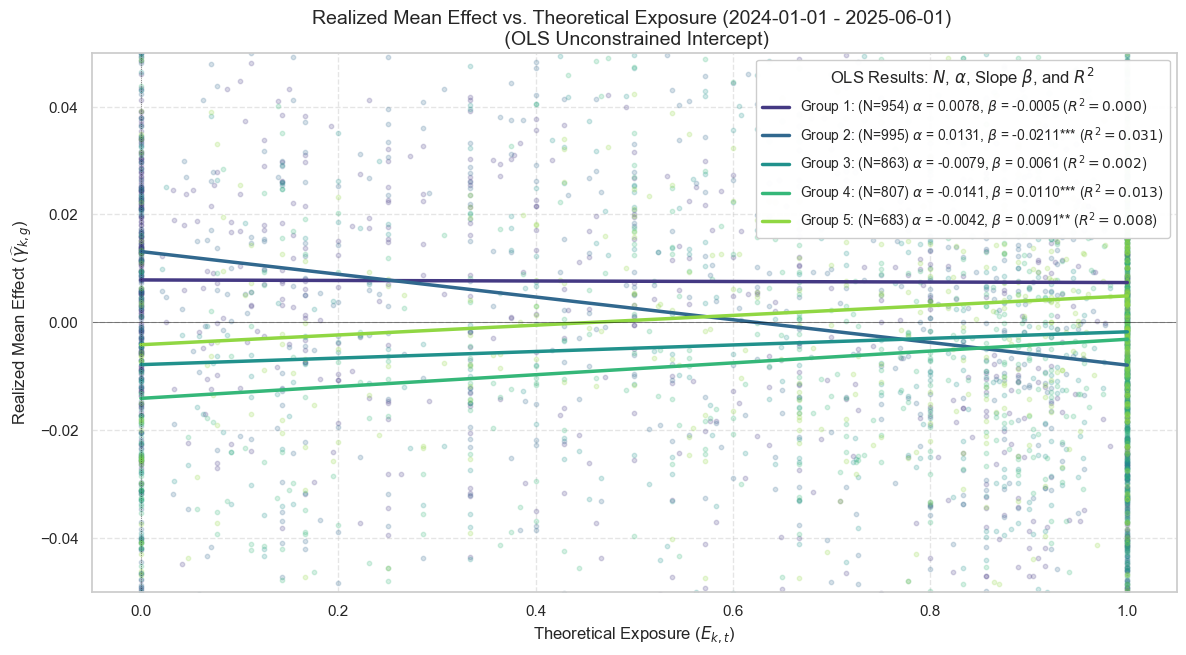

In [31]:
    
START_DATE = '2024-01-01'
END_DATE = '2025-06-01'

# Execute the main function
plot_ols_gradient(df_raw_data, START_DATE, END_DATE)

## Placebo


OLS Regression Results for: Group 1
                            OLS Regression Results                            
Dep. Variable:          beta_hat_Post   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     88.26
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           4.13e-20
Time:                        22:12:26   Log-Likelihood:                 2272.9
No. Observations:                 954   AIC:                            -4542.
Df Residuals:                     952   BIC:                            -4532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

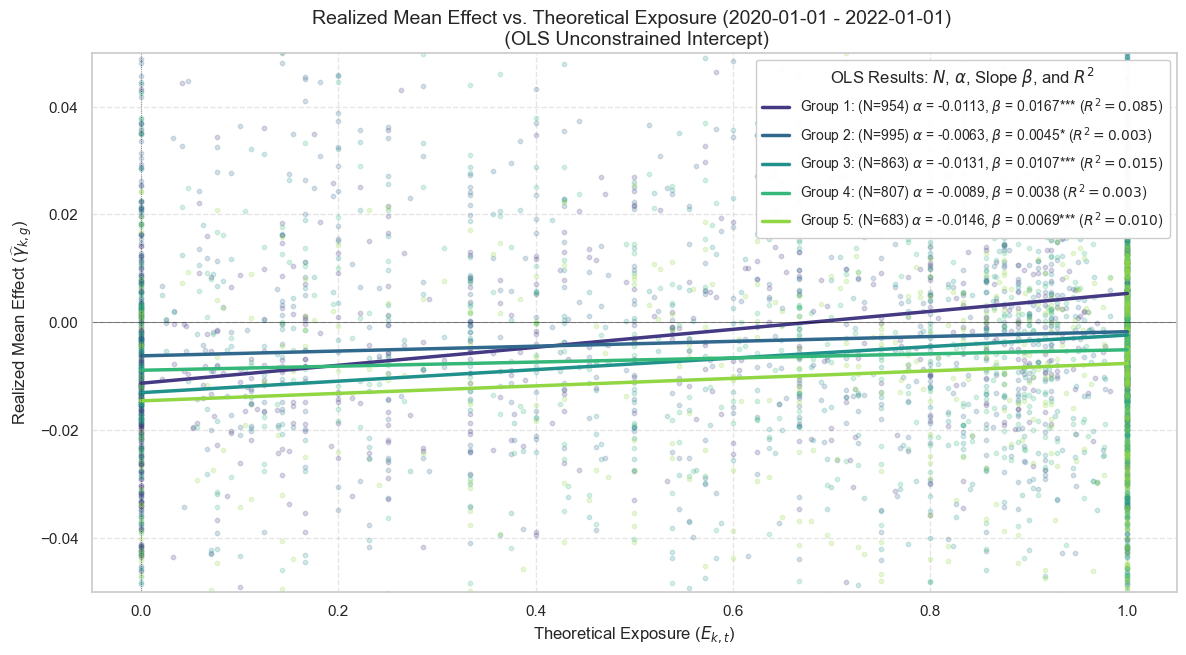

In [40]:
START_DATE = '2020-01-01'
END_DATE = '2022-01-01'

# Execute the main function
plot_ols_gradient(df_raw_data, START_DATE, END_DATE)

# Seniority

In [18]:
seniority_df = company_DWA_df.groupby(["seniority", "month"]).agg(
    effect_mean=('effect', 'mean'),
    se=('se', 'mean'))

In [21]:
seniority_df = seniority_df.reset_index()
seniority_df

,seniority,month,effect_mean,se
0,1,2021-01-01,-0.007189,0.016177
1,1,2021-02-01,-0.006297,0.015619
2,1,2021-03-01,-0.005460,0.015054
3,1,2021-04-01,-0.005266,0.014479
4,1,2021-05-01,-0.000355,0.013791
...,...,...,...,...
280,5,2025-05-01,0.003889,0.011849
281,5,2025-06-01,0.003894,0.012036
282,5,2025-07-01,0.003714,0.012181
283,5,2025-08-01,0.003627,0.012368


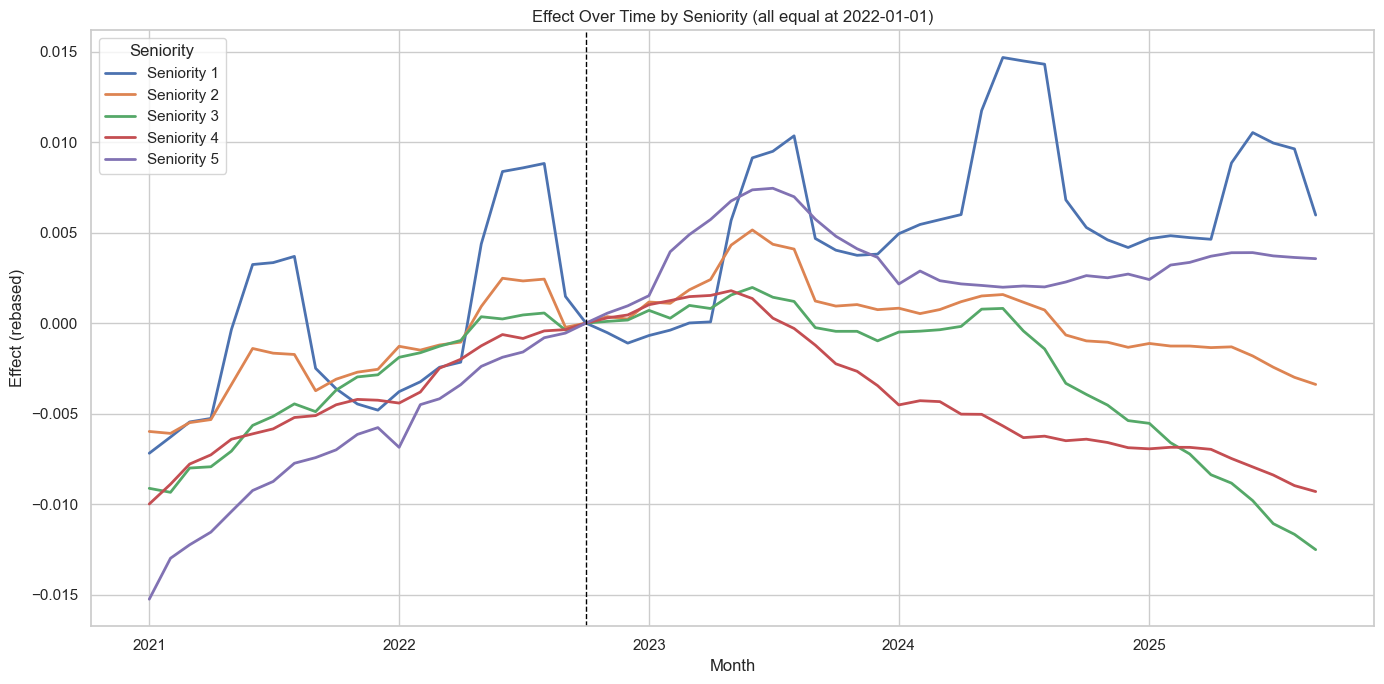

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = seniority_df.copy()
# Ensure datetime
plot_df['month'] = pd.to_datetime(plot_df['month'])

# --- STEP 1: anchor date ---
anchor_date = pd.Timestamp("2022-10-01")

# --- STEP 2: compute the shift needed for each seniority ---
anchor_vals = plot_df.loc[plot_df['month'] == anchor_date, ['seniority','effect_mean']]
shifts = anchor_vals.set_index('seniority')['effect_mean']

# --- STEP 3: apply the normalization ---
plot_df['effect_mean_adj'] = plot_df.apply(
    lambda r: r['effect_mean'] - shifts.loc[r['seniority']],
    axis=1
)

# --- STEP 4: plot without SE ---
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for s, df_s in plot_df.groupby('seniority'):
    plt.plot(df_s['month'], df_s['effect_mean_adj'], label=f"Seniority {s}", linewidth=2)

plt.axvline(anchor_date, color='black', linestyle='--', linewidth=1)
plt.xlabel("Month")
plt.ylabel("Effect (rebased)")
plt.title("Effect Over Time by Seniority (all equal at 2022-01-01)")
plt.legend(title="Seniority")
plt.tight_layout()
plt.show()


# Exposure evolution

/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_95504/2372654072.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = plot_df.groupby(['seniority', 'beta_quantile', 'month'])['effect'].mean().reset_index()
/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_95504/2372654072.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for quantile, df_quantile in df_seniority.groupby('beta_quantile'):


<Figure size 1400x700 with 0 Axes>

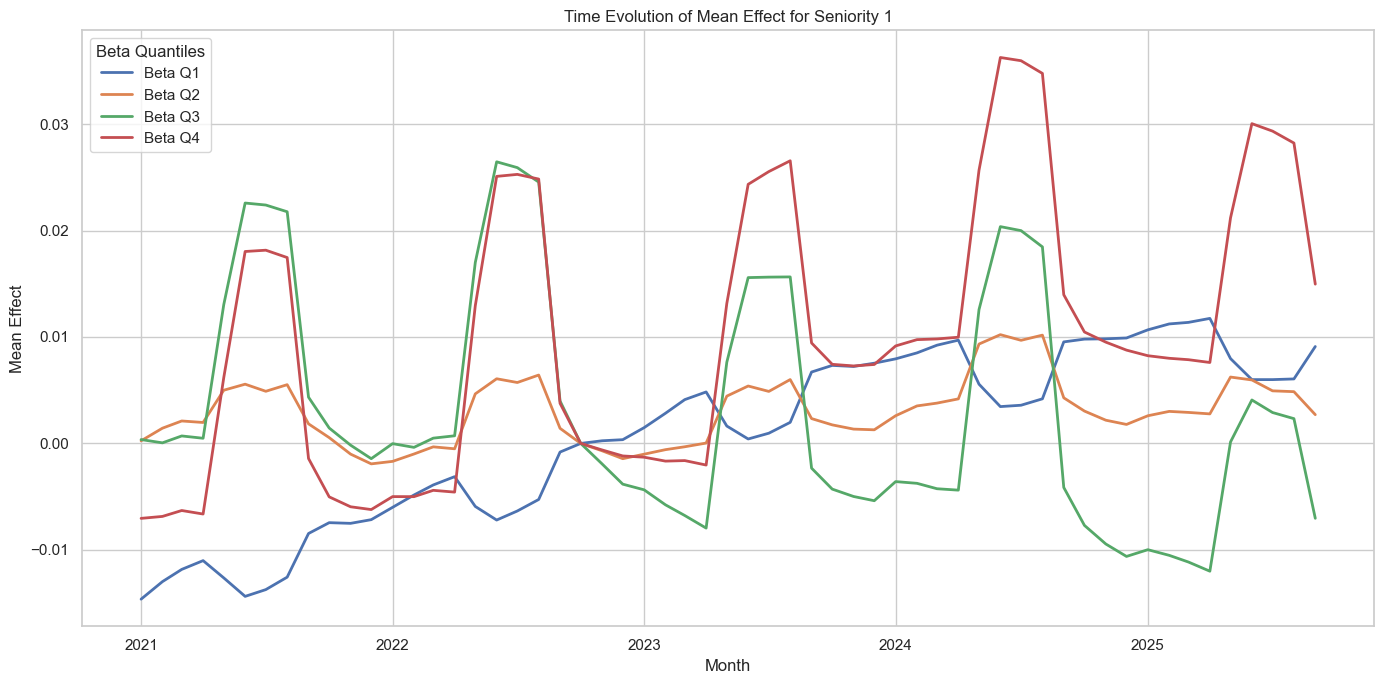

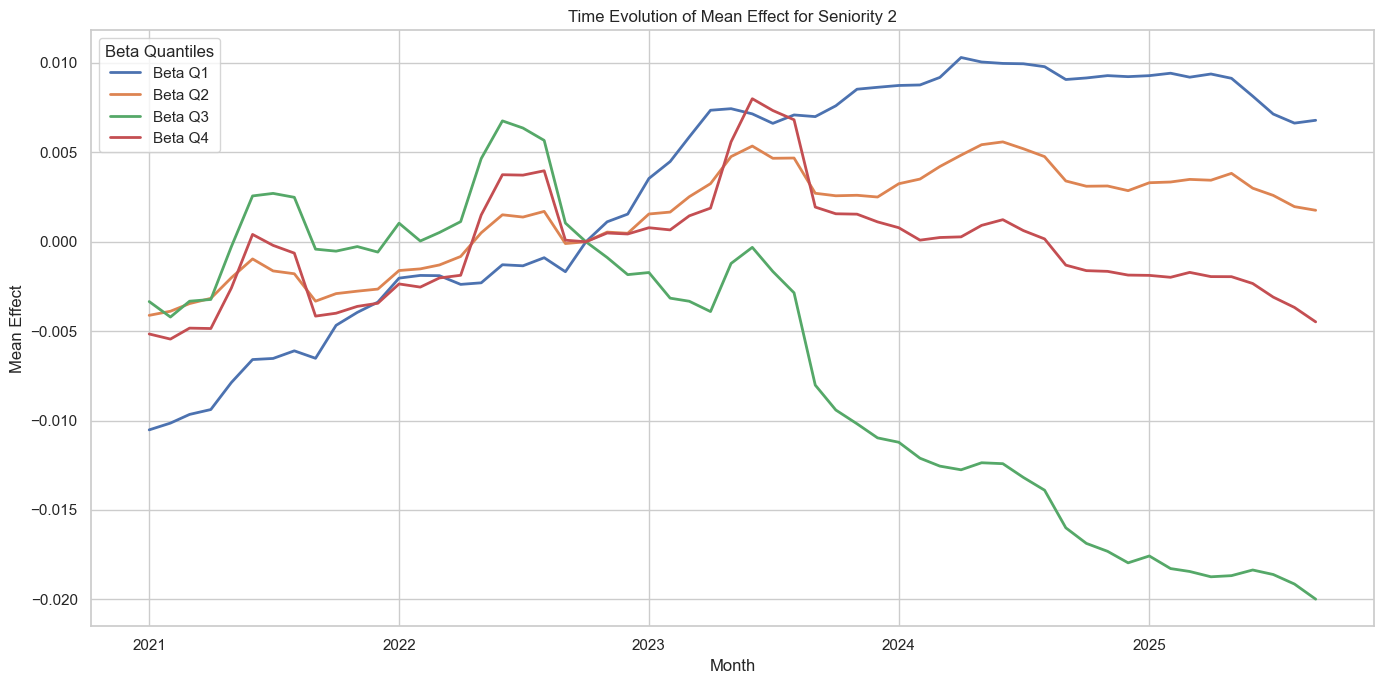

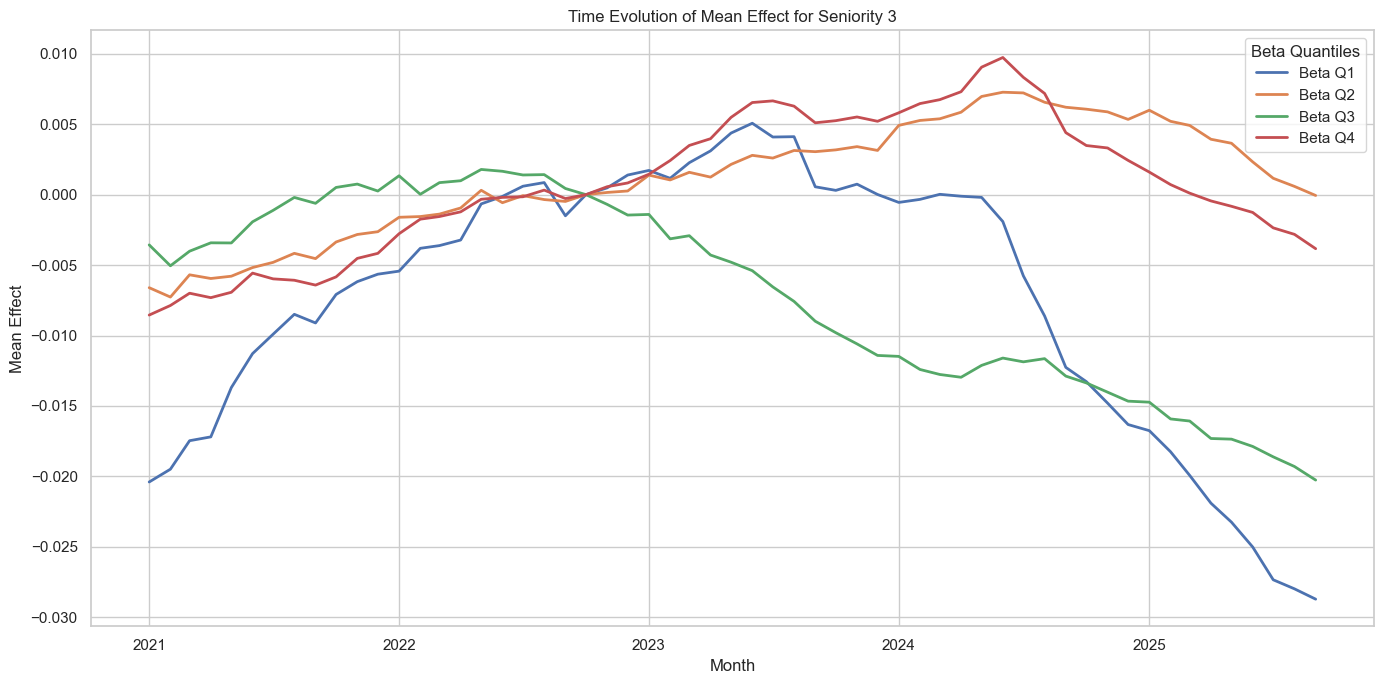

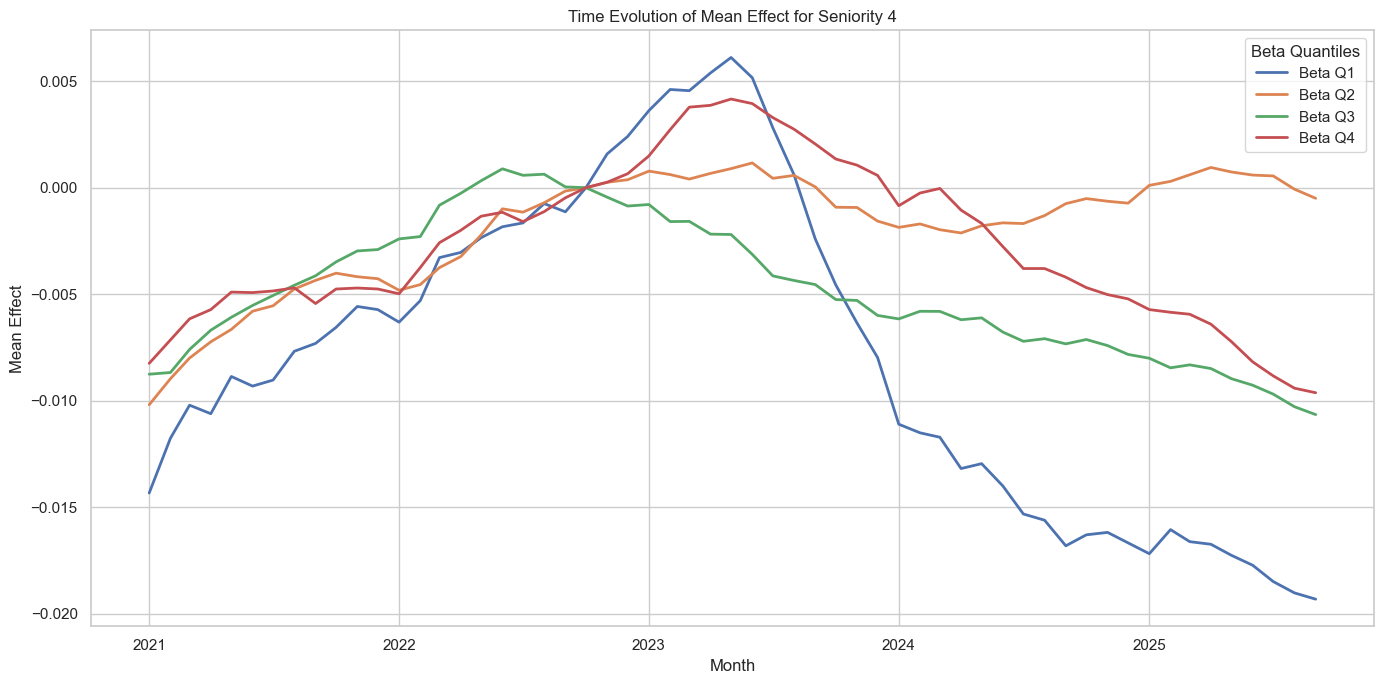

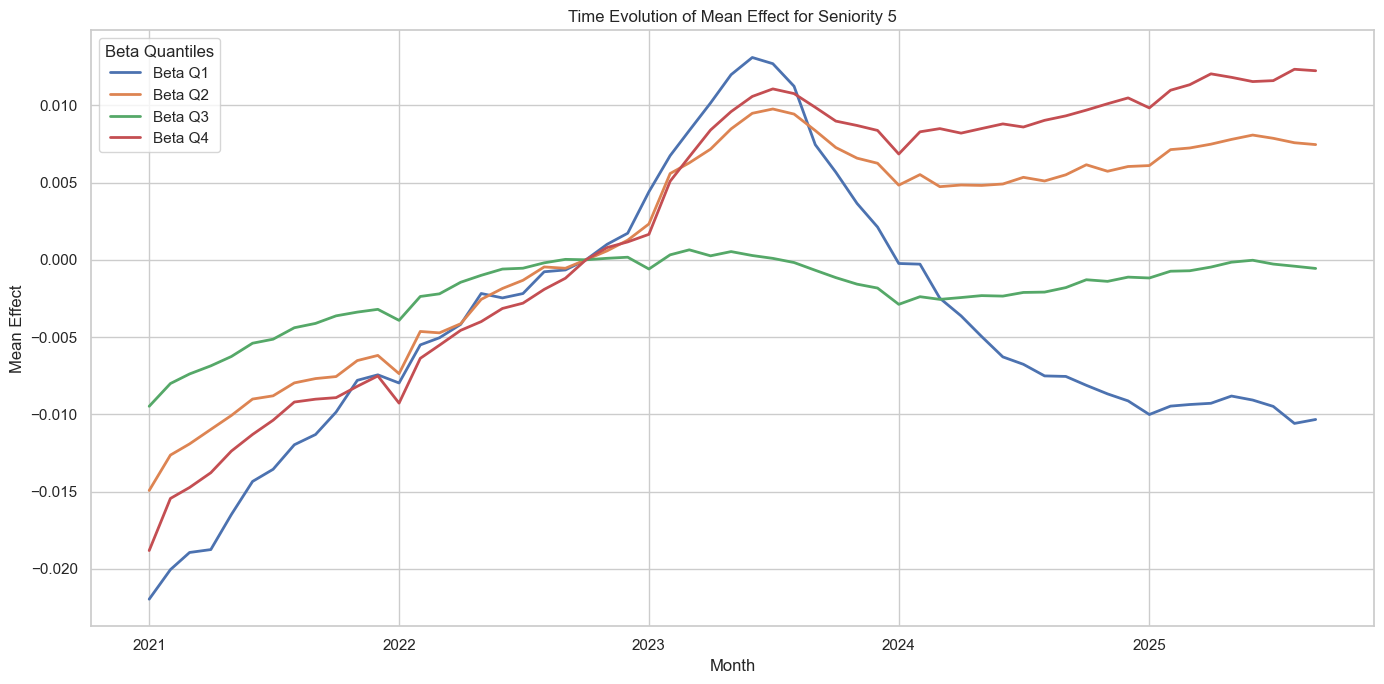

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you already have the `plot_df` dataframe loaded.
plot_df = company_DWA_merged_df.copy()
# Ensure 'month' column is datetime
plot_df['month'] = pd.to_datetime(plot_df['month'])

# --- STEP 1: Calculate Beta Quantiles ---
# We will split the beta values into 4 quantiles (quartiles)
plot_df['beta_quantile'] = pd.qcut(plot_df['beta'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# --- STEP 2: Group by seniority and beta_quantile, then calculate mean effect ---
# We will aggregate by seniority and beta quantile to get the mean effect for each group.
grouped_df = plot_df.groupby(['seniority', 'beta_quantile', 'month'])['effect'].mean().reset_index()

# --- STEP 3: Plotting ---
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot time evolution for each seniority and beta quantile
for seniority, df_seniority in grouped_df.groupby('seniority'):
    plt.figure(figsize=(14, 7))
    for quantile, df_quantile in df_seniority.groupby('beta_quantile'):
        plt.plot(df_quantile['month'], df_quantile['effect'], label=f"Beta {quantile}", linewidth=2)

    plt.title(f"Time Evolution of Mean Effect for Seniority {seniority}")
    plt.xlabel("Month")
    plt.ylabel("Mean Effect")
    plt.legend(title="Beta Quantiles")
    plt.tight_layout()
    plt.show()
